# Deep Learning avec PyTorch


## Deep learning pour le texte
L'objectif est d'apprivoiser les embeddings de mots, de tokens, ainsi que les architectures Transformer : 
- Chargement des embeddings pré-entrainés
- Manipulation des embeddings
- Visualuation des embeddings
- Classification de phrases courtes, en fonction de différentes représentations et architectures
- Classification de textes : Finetuning d'un Transformer pre-entraîné sur le corpus IMDB 

Prérequis (en plus de pytorch et numpy): 
- conda install pandas
- conda install matplotlib
- conda install -c anaconda scikit-learn
- conda install ipywidgets
- conda install gensim
- conda install datasets 
- conda install -c huggingface transformers
- conda install tqdm




 ## Configuration environnement

In [1]:
import torch

# pour colab, decommenter:    
# !pip install torch==1.8.0+cu111 torchtext==0.9.0 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html

print(torch.__version__)

2.1.0


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm

import pandas as pd
import numpy as np

import transformers
print(transformers.__version__)

/tmp/ipykernel_81539/449048064.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


4.31.0


## Chargement d'embeddings et calculs de similarité

Pour commencer à travailler sur le texte, nous allons dans un premier temps utiliser un ensemble de vecteurs d'embeddings appris via le modèle Glove (similaire à Word2Vec vu en cours), que nous allons charger via la librairie gensim (il s'agit d'un ensemble d'embeddings parmi d'autres, de nombreux autres, appris sur des corpus différents existent dans gensim ou d'autres librairies comme spacy). 

In [3]:
import gensim.downloader as api
embeds = api.load("glove-wiki-gigaword-50")

# affichage de l'embedding du mot "book"
print(embeds['book']) 




[-0.0076543  0.93456   -0.73189   -0.55162    0.76977    0.35925
 -1.1365    -1.1632     0.34214    0.29145   -0.8711     0.9197
 -0.47069   -0.22834    1.4777    -0.81714   -0.17466   -0.51093
 -0.28354    0.23292    0.71832    0.23414    0.49443    0.35483
  0.76889   -1.4374    -1.7457    -0.28994   -0.10156   -0.36959
  2.5502    -1.0581    -0.049416  -0.25524   -0.63303    0.02671
 -0.18733    0.20206   -0.26288   -0.41418    0.83473   -0.14227
 -0.28125    0.098155  -0.17096    0.52408    0.31851   -0.089847
 -0.27223   -0.0088736]


In [4]:
# Methode most_similar permet d'obtenir les mots les plus proches d'un mot dans l'espace d'embeddings. sa specification peut être obtenue en executant la ligne suivante : 
help(embeds.most_similar) 


Help on method most_similar in module gensim.models.keyedvectors:

most_similar(positive=None, negative=None, topn=10, clip_start=0, clip_end=None, restrict_vocab=None, indexer=None) method of gensim.models.keyedvectors.KeyedVectors instance
    Find the top-N most similar keys.
    Positive keys contribute positively towards the similarity, negative keys negatively.

    This method computes cosine similarity between a simple mean of the projection
    weight vectors of the given keys and the vectors for each key in the model.
    The method corresponds to the `word-analogy` and `distance` scripts in the original
    word2vec implementation.

    Parameters
    ----------
    positive : list of (str or int or ndarray) or list of ((str,float) or (int,float) or (ndarray,float)), optional
        List of keys that contribute positively. If tuple, second element specifies the weight (default `1.0`)
    negative : list of (str or int or ndarray) or list of ((str,float) or (int,float) or (n

Afficher les 5 mots les plus proches de "cat" via la méthode model.most_similar

In [5]:
#[[Student/]]
embeds.most_similar(["cat"],topn=5)
#[[/Student]]


[('dog', 0.9218006134033203),
 ('rabbit', 0.8487821221351624),
 ('monkey', 0.8041081428527832),
 ('rat', 0.7891963124275208),
 ('cats', 0.7865270972251892)]

In [6]:
# La similarité est calculée selon une mesure de cosinus dans l'espace des embeddings
# par exemple
print(embeds.similarity("apple", "banana"))
print(embeds.similarity("apple", "dog"))

0.5607928
0.4138724


### Out Of Distribution 
Attention, bien sûr tous les mots possibles ne sont pas inclus dans le dictionnaire d'embeddings, leur sémantique dépend notamment fortement du corpus sur lequel ils ont été appris.

Par exemple le mot "covid" n'est pas présent, l'execution de model['covid'] ferait planter l'execution.

Pour éviter ce genre de problème par exemple pour le traitement d'un texte ne contenant pas certains mots, ils convient de vérifier leur présence dans le vocabulaire (et alors ignorer les mots correspondants). Ceci peut se faire via vocab.keys comme ci-dessous. 

In [7]:
# Le vocabulaire du modèle peut être obtenus via vocab.keys, qui retourne l'ensemble des tokens (mots) pour lesquels il existe un embedding dans le modèle
vocab = embeds.key_to_index.keys()
np.random.choice(list(vocab), 5)

x="covid"
if x in vocab:
    print(embeds[x])
else: print("oov")



oov


### Visualisation des embeddings

On souhaite maintenant visualiser les embeddings dans un espace en 2D. Pour cela, on utilise t-SNE.

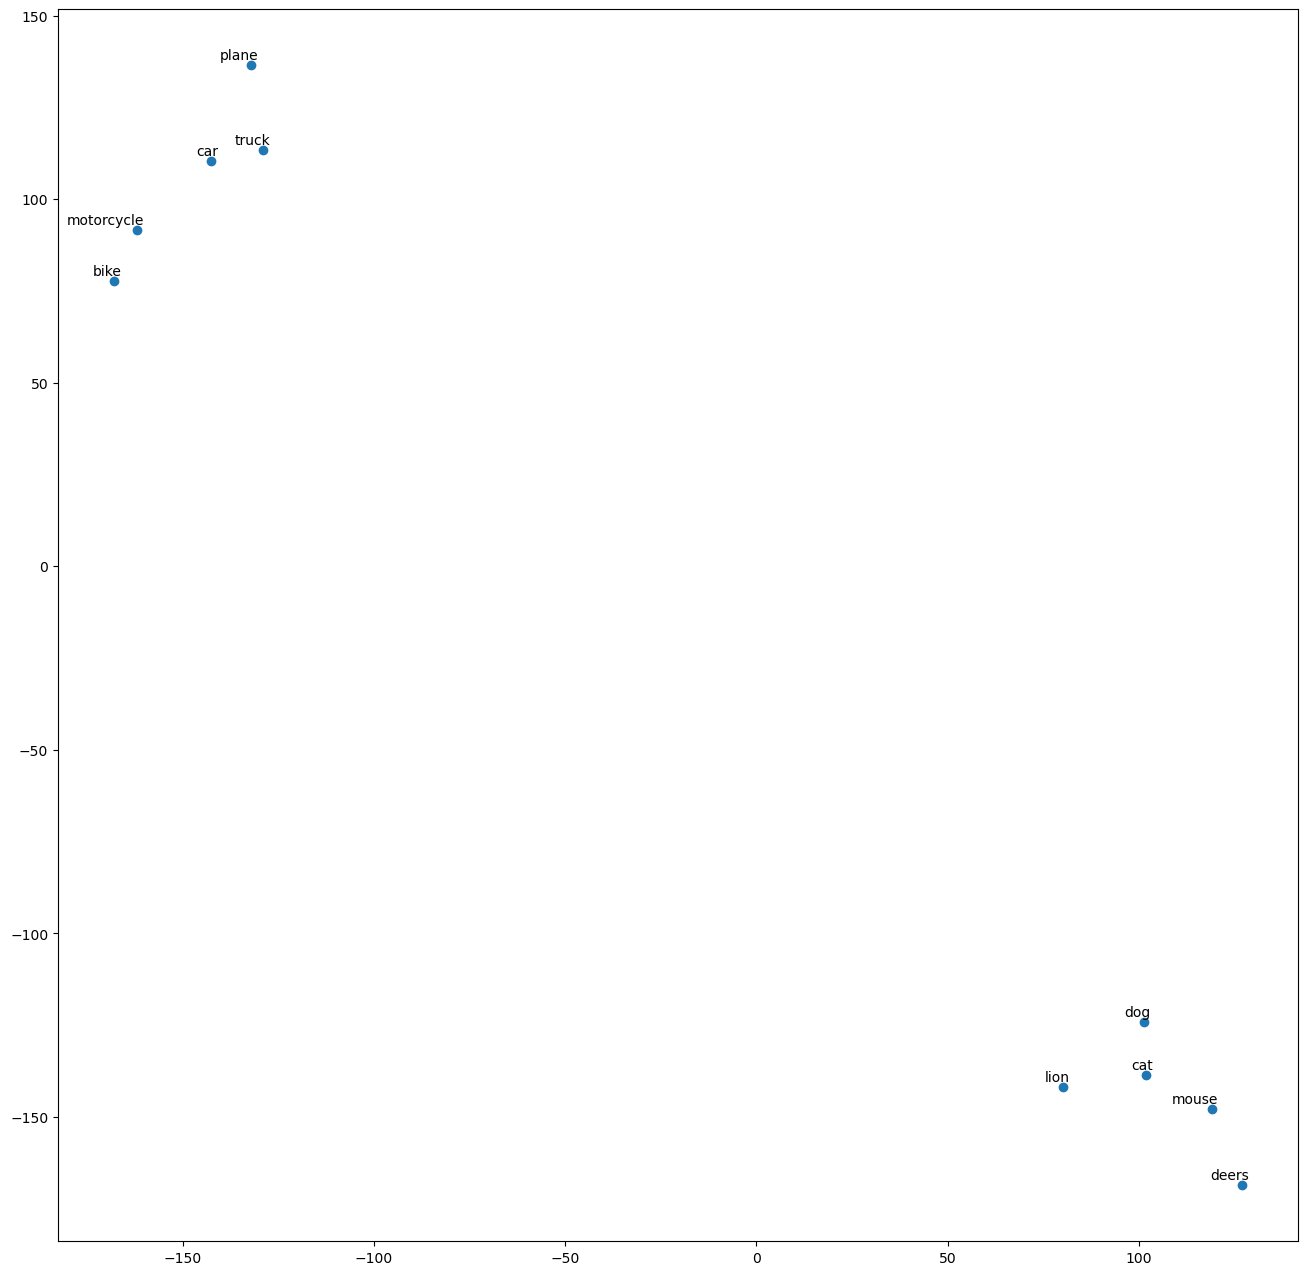

In [8]:
words=['cat','mouse','dog','car','truck','motorcycle','bike','lion','plane','deers']

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def tsne_plot(model, words,n_components=2,perplexity=40):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []
    vocab = model.key_to_index.keys()
    
    for word in words:
        if word in vocab: 
            tokens.append(model[word])
            labels.append(word)

    tsne_model = TSNE(perplexity=perplexity, n_components=n_components, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(np.array(tokens))
    fig = plt.figure(figsize=(16, 16))
    if n_components==3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(new_values[:,0],new_values[:,1],new_values[:,2],c="r",marker="o")
        for i in range(len(new_values)):
            ax.text(new_values[i][0],new_values[i][1],new_values[i][2],labels[i])
    else:
        plt.scatter(new_values[:,0],new_values[:,1])
        for i in range(len(new_values)):
            plt.annotate(labels[i],
                        xy=(new_values[i][0],new_values[i][1]),
                        xytext=(5, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
    return new_values,labels

new_values,labels = tsne_plot(embeds,words,n_components=2,perplexity=2)

### Index des Embeddings

Lors de l'établissement de modèles utilisant les embeddings du vocabulaire, il est utile de considérer des indices des mots dans le vocabulaire plutôt que les mots eux mêmes (pour les traiter par exemple dans des tenseurs avant de les remplacer par leurs vecteurs de poids). Ceci se fait dans gensim par l'utilisation des instructions suivantes:  

In [9]:
print(embeds.key_to_index["book"])
print(embeds.index_to_key[539])

# Deux manières equivalentes de recupérer les poids
print(embeds["book"])   # via le mot 
print(embeds.vectors[embeds.key_to_index["book"]]) #via l'index


# taille du vocabulaire: 
print(embeds.vectors.shape)


539
book
[-0.0076543  0.93456   -0.73189   -0.55162    0.76977    0.35925
 -1.1365    -1.1632     0.34214    0.29145   -0.8711     0.9197
 -0.47069   -0.22834    1.4777    -0.81714   -0.17466   -0.51093
 -0.28354    0.23292    0.71832    0.23414    0.49443    0.35483
  0.76889   -1.4374    -1.7457    -0.28994   -0.10156   -0.36959
  2.5502    -1.0581    -0.049416  -0.25524   -0.63303    0.02671
 -0.18733    0.20206   -0.26288   -0.41418    0.83473   -0.14227
 -0.28125    0.098155  -0.17096    0.52408    0.31851   -0.089847
 -0.27223   -0.0088736]
[-0.0076543  0.93456   -0.73189   -0.55162    0.76977    0.35925
 -1.1365    -1.1632     0.34214    0.29145   -0.8711     0.9197
 -0.47069   -0.22834    1.4777    -0.81714   -0.17466   -0.51093
 -0.28354    0.23292    0.71832    0.23414    0.49443    0.35483
  0.76889   -1.4374    -1.7457    -0.28994   -0.10156   -0.36959
  2.5502    -1.0581    -0.049416  -0.25524   -0.63303    0.02671
 -0.18733    0.20206   -0.26288   -0.41418    0.83473   -0

#### Similarité de phrases

On souhaite calculer la matrice de similarité de différentes phrases du dataset suivant:




In [10]:
tdf = pd.DataFrame([
    ['the road is straight', 'Y'],
    ['the black cat plays with a ball', 'N'],
    ['a big dog with a ball', 'N'],
    ['dog and cat are together', 'N'],
    ['traffic jam on the 6th road', 'Y'],
    ['white bird on a big tree', 'N'],
    ['a big truck', 'Y'],
    ['two cars crashed', 'Y'],
    ['two deers in a field', 'N'],
    ['I like ridding my bike','Y'],
    ['a lion in the savane','N'],
    ['a motorcycle rides on the road','Y'],
    ['it is a bike, it is not a flamingo', 'Y'], 
    ['it is not a bike, it is a flamingo', 'N'],
    ['a mouse bitten by a cat','N'],
    ['two pigs in the mood','N'],
    ['take a plane is sometimes slower than taking train','Y'],
    ['take the highway','Y']
], columns=['text', 'label'])
tdf


,text,label
0,the road is straight,Y
1,the black cat plays with a ball,N
2,a big dog with a ball,N
3,dog and cat are together,N
4,traffic jam on the 6th road,Y
5,white bird on a big tree,N
6,a big truck,Y
7,two cars crashed,Y
8,two deers in a field,N
9,I like ridding my bike,Y


Pour chaque phrase, on va moyenner les embeddings de ces mots. Chaque vecteur de phrase sera normalisé (x.norm()). Les phrases pourront être comparées deux à deux par un produit scalaire.

- chaque phrase doit être découpée : ("the", "cat", "is" , "on", "the","bank")
- on définit une fonction getvectors qui à partir de la liste de phrases découpées : moyenne les vecteurs d'embeddings (pensez à utiliser les tenseurs de torch), normalise le resultat et le retourne. 
- on peut ensuite calculer la matrice de similarité qui sera donnée à la fonction visual_similarity_matrix() fournie ci-dessous.

In [12]:

# Premiere possibilité :
def getlistwordsentence(text):
    ret=[]
    for sentence in text:
        print(sentence)
        ret.append(sentence.split(" "))
    return ret


# Deuxième possibilité (plus robuste, gère la ponctuation, etc.):
import gensim
def getlistwordsentence2(text):
    ret=[]
    for sentence in text:
        ret.append(list(gensim.utils.tokenize(sentence)))
    return ret

text_wordlist = getlistwordsentence2(tdf['text'])
print(text_wordlist)

def getvectors(wordslist, normalize=True):
    l = []
    s = []
    knon_words = embeds.key_to_index.keys()
    for words in wordslist:
        x = torch.cat(([torch.Tensor(embeds[x]).view(1,-1) for x in words if x in knon_words]),0)
        x = x.mean(0)
        if normalize:
            x/=x.norm(dim=-1)
        l.append(x)
        s.append(" ".join(words))
    return torch.stack(l), s
    

x, sentences = getvectors(text_wordlist,True)

print(x)
print(sentences)

def getSims(x):
    return x@x.t()

innerproducts=getSims(x)

[['the', 'road', 'is', 'straight'], ['the', 'black', 'cat', 'plays', 'with', 'a', 'ball'], ['a', 'big', 'dog', 'with', 'a', 'ball'], ['dog', 'and', 'cat', 'are', 'together'], ['traffic', 'jam', 'on', 'the', 'th', 'road'], ['white', 'bird', 'on', 'a', 'big', 'tree'], ['a', 'big', 'truck'], ['two', 'cars', 'crashed'], ['two', 'deers', 'in', 'a', 'field'], ['I', 'like', 'ridding', 'my', 'bike'], ['a', 'lion', 'in', 'the', 'savane'], ['a', 'motorcycle', 'rides', 'on', 'the', 'road'], ['it', 'is', 'a', 'bike', 'it', 'is', 'not', 'a', 'flamingo'], ['it', 'is', 'not', 'a', 'bike', 'it', 'is', 'a', 'flamingo'], ['a', 'mouse', 'bitten', 'by', 'a', 'cat'], ['two', 'pigs', 'in', 'the', 'mood'], ['take', 'a', 'plane', 'is', 'sometimes', 'slower', 'than', 'taking', 'train'], ['take', 'the', 'highway']]
tensor([[-2.0428e-03,  1.2294e-01, -2.5053e-02,  3.8993e-02,  3.7583e-02,
          2.6519e-02, -1.1185e-01, -2.6247e-02,  2.7497e-02, -9.6953e-02,
         -6.0345e-02, -6.9913e-02, -1.8141e-01, -5.

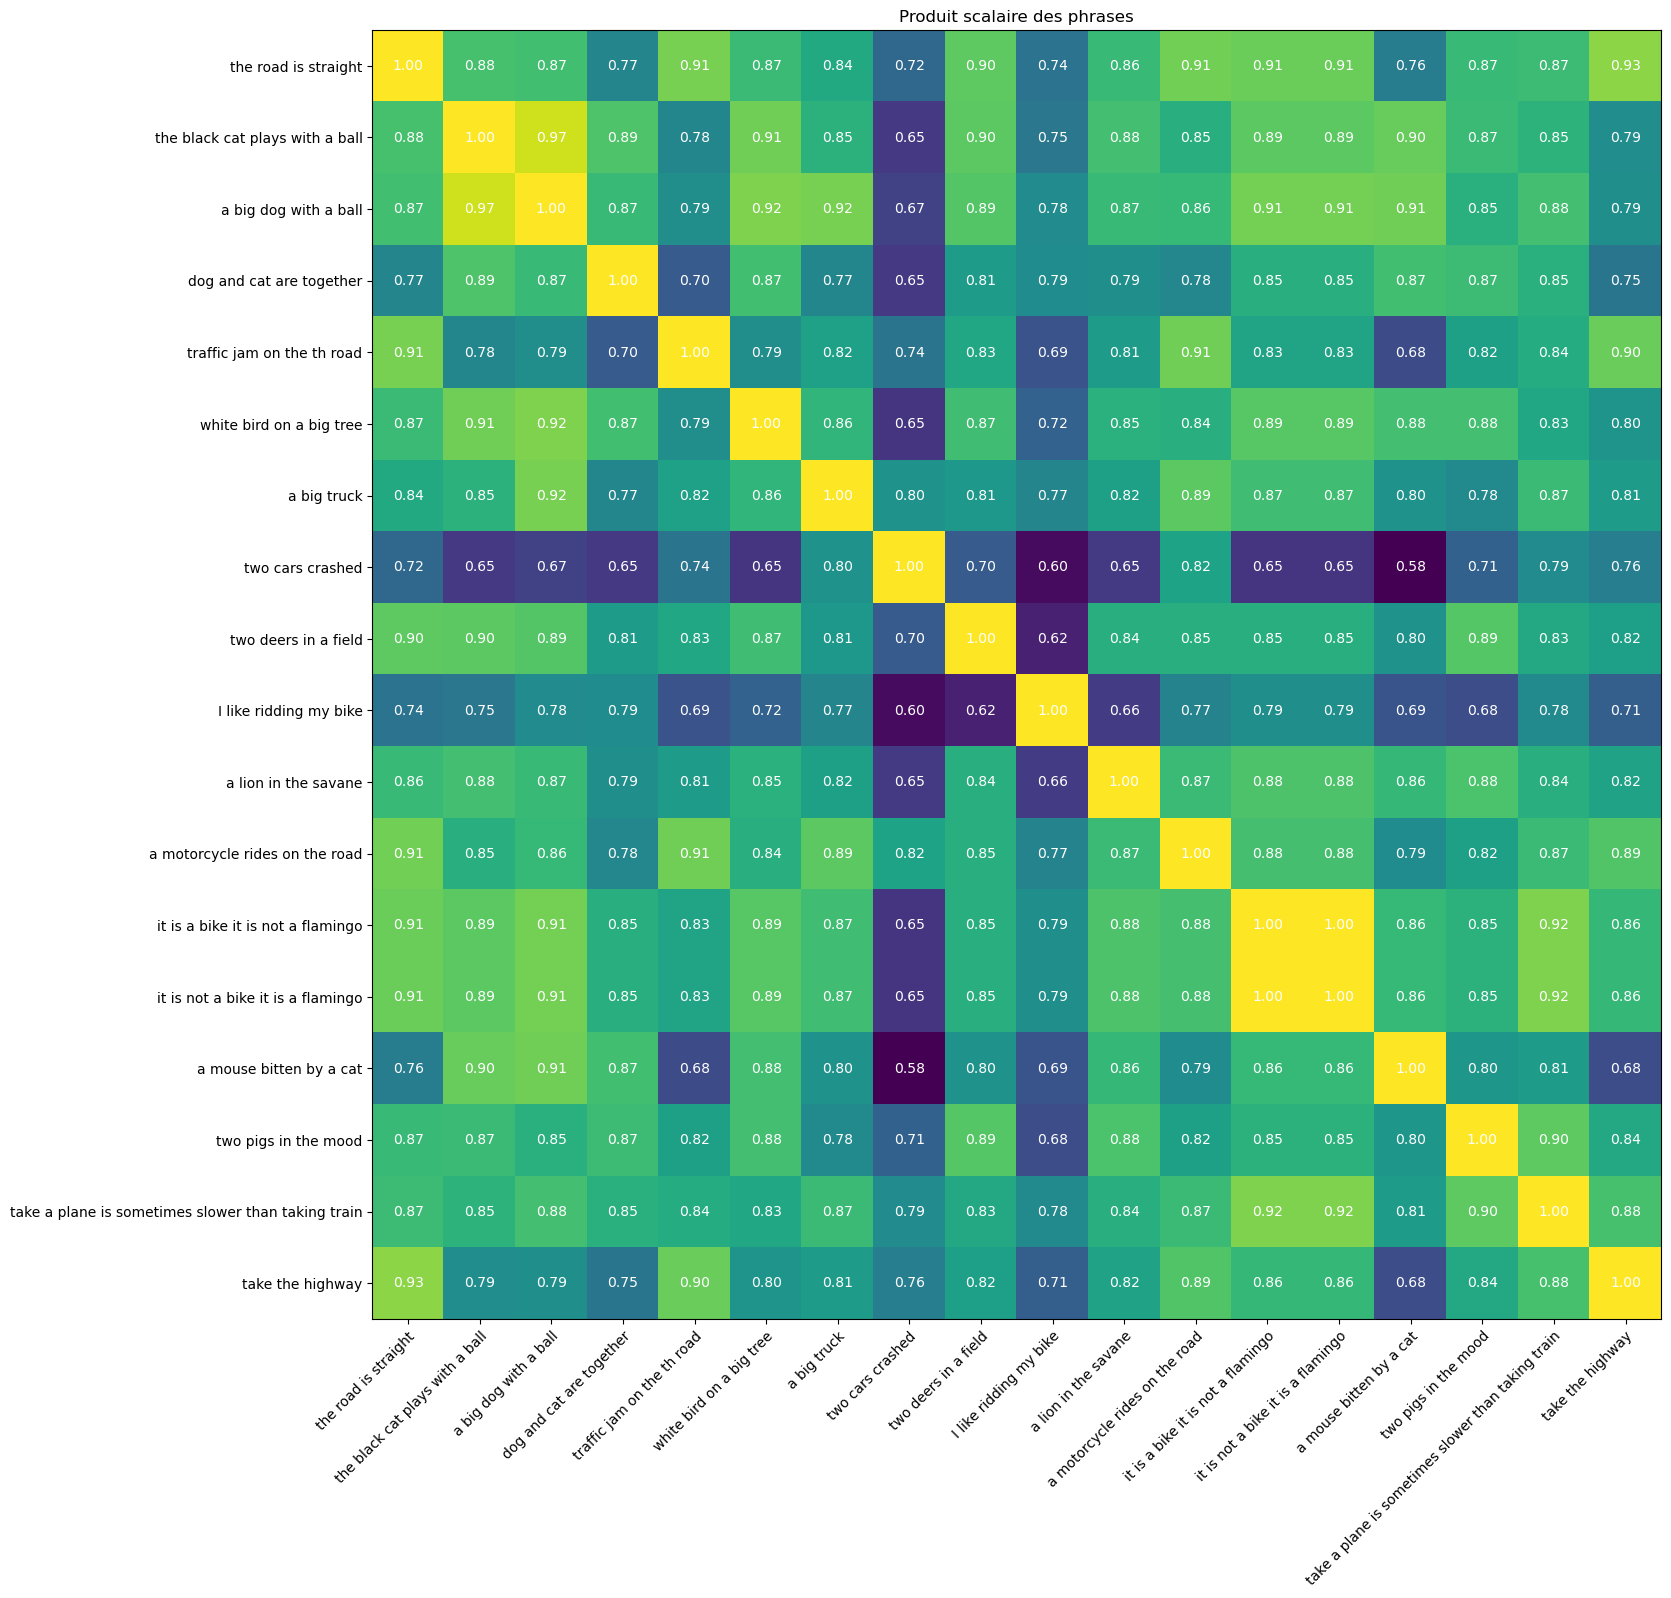

In [13]:
def visual_similarity_matrix(innerproducts):
  fig, ax = plt.subplots()
  im = ax.imshow(innerproducts)

  # We want to show all ticks...
  ax.set_xticks(np.arange(len(sentences)))
  ax.set_yticks(np.arange(len(sentences)))
  # ... and label them with the respective list entries
  ax.set_xticklabels(sentences)
  ax.set_yticklabels(sentences)

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(sentences)):
    for j in range(len(sentences)):
      text = ax.text(j, i, "%.2f" % innerproducts[i, j],
                       ha="center", va="center", color="w")

  ax.set_title("Produit scalaire des phrases")
  fig.tight_layout()
  fig.set_size_inches(38.5, 38.5)
  plt.show()

visual_similarity_matrix(innerproducts)

## Utilisation des embeddings pour une tâche de classification

On s'intéresse maintenant à apprendre un classifieur sur les données de l'exemple jouet défini ci dessus. On utilisera le jeu de données suivant comme jeu de validation :



In [14]:
vdf = pd.DataFrame([
    ['the bike drives on the road', 'Y'],
    ['a lion and a cat in a tree', 'N'],
    ['two cars crashed', 'Y'],
    ['i always go to work by bike', 'Y'],
    ['i have no animal at home', 'N'],
    ['dogs like cheese', 'N'], 
    ['a pink flamingo','N'],
    ['trucks','Y'],
    ['truckks','Y'],
    ['truckmegatruck', 'Y'], 
    ['a text about trucks, not animals','Y'], 
    ['a text about animals, not trucks','N'],
    ['doggs','N']
], columns=['text', 'label'])
vdf

,text,label
0,the bike drives on the road,Y
1,a lion and a cat in a tree,N
2,two cars crashed,Y
3,i always go to work by bike,Y
4,i have no animal at home,N
5,dogs like cheese,N
6,a pink flamingo,N
7,trucks,Y
8,truckks,Y
9,truckmegatruck,Y


La première étape  consiste à transformer les données (label numérique, tokenization, construction d'un batch.)

In [15]:
import datasets
from datasets import Dataset, DatasetDict

train_dataset = Dataset.from_pandas(tdf)
validation_dataset = Dataset.from_pandas(vdf)
print(train_dataset,validation_dataset)
print(train_dataset["text"])

# Creation d'un index de padding pour les positions a ignorer par le modèle (e.g., mots inconnus)
pad_idx=embeds.vectors.shape[0]

def preprocess_function(examples):
    vocab=embeds.key_to_index
    inputs= getlistwordsentence2(examples["text"])
    
    inputs = [[(vocab[word] if word in vocab else pad_idx) for word in sentence] for sentence in inputs] 
    
    labels = [(1 if l=='Y' else 0) for l in examples["label"]] 
    ret = {}
    ret["input_ids"]=inputs
    ret["labels"]=labels
    
    return ret


train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.features.keys(), load_from_cache_file=True)
print(train_dataset)
print(train_dataset["input_ids"])
validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.features.keys(), load_from_cache_file=True)
print(validation_dataset)
print(validation_dataset["input_ids"])

Dataset({
    features: ['text', 'label'],
    num_rows: 18
}) Dataset({
    features: ['text', 'label'],
    num_rows: 13
})
['the road is straight', 'the black cat plays with a ball', 'a big dog with a ball', 'dog and cat are together', 'traffic jam on the 6th road', 'white bird on a big tree', 'a big truck', 'two cars crashed', 'two deers in a field', 'I like ridding my bike', 'a lion in the savane', 'a motorcycle rides on the road', 'it is a bike, it is not a flamingo', 'it is not a bike, it is a flamingo', 'a mouse bitten by a cat', 'two pigs in the mood', 'take a plane is sometimes slower than taking train', 'take the highway']


Map: 100%|██████████| 18/18 [00:00<00:00, 2759.51 examples/s]


Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 18
})
[[0, 586, 14, 1362], [0, 521, 5450, 1381, 17, 7, 1083], [7, 365, 2926, 17, 7, 1083], [2926, 5, 5450, 32, 600], [1596, 8202, 13, 0, 14358, 586], [298, 2632, 13, 7, 365, 2654], [7, 365, 2575], [55, 1277, 3732], [55, 134183, 6, 7, 610], [400000, 117, 40085, 192, 7696], [7, 6657, 6, 0, 232439], [7, 7213, 9371, 13, 0, 586], [20, 14, 7, 7696, 20, 14, 36, 7, 35115], [20, 14, 36, 7, 7696, 20, 14, 7, 35115], [7, 7571, 22022, 21, 7, 5450], [55, 9609, 6, 0, 5030], [190, 7, 1313, 14, 1071, 6914, 73, 582, 1470], [190, 0, 1883]]


Map: 100%|██████████| 13/13 [00:00<00:00, 7574.10 examples/s]

Dataset({
    features: ['input_ids', 'labels'],
    num_rows: 13
})
[[0, 7696, 5919, 13, 0, 586], [7, 6657, 5, 7, 5450, 6, 7, 2654], [55, 1277, 3732], [41, 690, 242, 4, 161, 21, 7696], [41, 33, 84, 2694, 22, 163], [3876, 117, 5795], [7, 5491, 35115], [3597], [400000], [400000], [7, 2829, 59, 3597, 36, 2430], [7, 2829, 59, 2430, 36, 3597], [400000]]


In [ ]:
from torch.utils.data import DataLoader
from transformers.trainer_pt_utils import LengthGroupedSampler,Sampler,get_length_grouped_indices

batchsize=4
megabatch_mul=16


# Un sampler permet de générer les batchs en selectionnant des indices d'échantillons de manière aléatoire
# dans les données d'entrée
# Ici on souhaite minimiser le padding, donc on choisit de regrouper au maximum les sequences par longueur 
# dans les batchs
# C'est fait selon les étapes suivantes :  
#     1 - Tirage d'une permutation des indices de manière aléatoire
#     2 - Découpage de la liste en megabatchs de taille batch_size*megabatch_mul
#     3 - Tri des éléments par ordre de longueur déscendante à l'intérieur de chaque megabatch
#     4 - Concaténation des listes d'indices retriées localement 
#     5 - Découpage en batch de taille batchsize
#
# Ainsi:
#     - si megabatch_mul trop grand, alors aucun aléatoire (ce qui peu être gênant pour l'apprentissage dans certains cas)
#                                   ==> les batchs seront toujours les mêmes (données triées par longueur, minimisation optimale du padding)
#     - si megabatch_mul trop petit (e.g. = 1), alors batchs complètement aléatoires (séquences simplement ordonnées à l'intérieur du batch, pas d'optimisation sur la minimisation du padding) 
#                                   ==> beaucoup de padding possible (rajoute de la complexité à l'apprentissage)
#
# Il s'agit de trouver un bon compromis, jouer en tp avec les valeurs de megabatch_mul et observer les effets
class LengthGroupedSampler(Sampler):
    r"""
    Sampler that samples indices in a way that groups together features of the dataset of roughly the same length while
    keeping a bit of randomness.
    """

    def __init__(self,batch_size,dataset, megabatch_mul=None):
        self.batch_size = batch_size
        lengths = [len(sample["input_ids"]) for sample in dataset]
        self.lengths = lengths
        self.megabatch_mul=megabatch_mul

    def __len__(self):
        return len(self.lengths)

    def __iter__(self):
        indices = get_length_grouped_indices(self.lengths, self.batch_size, self.megabatch_mul)
        return iter(indices)

    
# Fonction qui produit des tenseurs pytorch a partir d'un batch de données issu du sampler
#
# ici on crée deux tenseurs par batch :
#         - un tenseur pour les labels
#         - un tenseur pour les index de mots des séquences, complétées avec l'idex de padding pad_idx pour les séquences plus courtes (afin d'avoir des données de même taille sur chaque ligne du tenseur, ce qui est requis pour leur création) 
def data_collator(batch):
    first = batch[0]
    ret = {}
    dtype = torch.long if type(first["labels"]) is int else torch.float
    ret["labels"] = torch.tensor([f["labels"] for f in batch], dtype=dtype)
    longest=max([len(l["input_ids"]) for l in batch])
    s = np.stack([np.pad(x["input_ids"], (0, longest - len(x["input_ids"])), constant_values=pad_idx) for x in batch])
    ret["input_ids"] = torch.tensor(s)
    return ret


train_sampler = LengthGroupedSampler(batchsize, train_dataset, megabatch_mul)

train_loader=DataLoader(train_dataset,batchsize,sampler=train_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)

for data in train_loader:
    print(data)

test_sampler = LengthGroupedSampler(batchsize, validation_dataset, megabatch_mul)    
    
test_loader=DataLoader(validation_dataset,batchsize,sampler=test_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)


for data in test_loader:
    print(data)


{'labels': tensor([1, 0, 1, 0]), 'input_ids': tensor([[   190,      7,   1313,     14,   1071,   6914,     73,    582,   1470],
        [    20,     14,     36,      7,   7696,     20,     14,      7,  35115],
        [    20,     14,      7,   7696,     20,     14,     36,      7,  35115],
        [     0,    521,   5450,   1381,     17,      7,   1083, 400000, 400000]])}
{'labels': tensor([0, 0, 1, 0]), 'input_ids': tensor([[    7,   365,  2926,    17,     7,  1083],
        [  298,  2632,    13,     7,   365,  2654],
        [    7,  7213,  9371,    13,     0,   586],
        [    7,  7571, 22022,    21,     7,  5450]])}
{'labels': tensor([1, 0, 0, 0]), 'input_ids': tensor([[  1596,   8202,     13,      0,  14358,    586],
        [    55, 134183,      6,      7,    610, 400000],
        [     7,   6657,      6,      0, 232439, 400000],
        [    55,   9609,      6,      0,   5030, 400000]])}
{'labels': tensor([0, 1, 1, 1]), 'input_ids': tensor([[  2926,      5,   5450,     32,  

In [17]:
### On peut créer une fonction de décodage des batchs
def batch_decode(input_ids):
    x=input_ids.data
    x=[" ".join([embeds.index_to_key[i] for i in s if i!=pad_idx]) for s in x]
    return x

for data in test_loader:
    print(data)
    print(batch_decode(data["input_ids"]))



{'labels': tensor([0, 1, 1, 0]), 'input_ids': tensor([[     7,   6657,      5,      7,   5450,      6,      7,   2654],
        [    41,    690,    242,      4,    161,     21,   7696, 400000],
        [     0,   7696,   5919,     13,      0,    586, 400000, 400000],
        [     7,   2829,     59,   2430,     36,   3597, 400000, 400000]])}
['a lion and a cat in a tree', 'i always go to work by bike', 'the bike drives on the road', 'a text about animals not trucks']
{'labels': tensor([1, 0, 1, 0]), 'input_ids': tensor([[     7,   2829,     59,   3597,     36,   2430],
        [    41,     33,     84,   2694,     22,    163],
        [    55,   1277,   3732, 400000, 400000, 400000],
        [  3876,    117,   5795, 400000, 400000, 400000]])}
['a text about trucks not animals', 'i have no animal at home', 'two cars crashed', 'dogs like cheese']
{'labels': tensor([0, 0, 1, 1]), 'input_ids': tensor([[     7,   5491,  35115],
        [400000, 400000, 400000],
        [400000, 400000, 40000

On note que le dernier texte "truckmegatruck" est décodé sous la chaîne vide: il ne contient que des mots inconnus, donc ignorés... 

### Modèle de classifcation simple

On construit ensuite le modèle de classification avec torch. La couche d'entrée correspond aux embeddings, implémentés par nn.Embedding(). nn.Embedding() permet de construire la matrice d'embeddings sur l'ensemble du vocabulaire. Ils sont ensuite "activés" en fonction du texte d'entrée. Le modèle à construire fait une simple moyenne des embeddings des mots des textes, applique une activation tanh et envoie le resultat à travers un Linear à deux sorties. Penser à indiquer l'index de padding à la construction de nn.Embedding, car çà permet de ne pas les prendre en compte dans les calculs de gradients (et de conserver ces embeddings vides à zeros pour ne pas en dépendre => invariance par rapport à la longueur). Penser aussi à ajouter de la l2 sur les embeddings (très importants pour que les représentations ne s'éparpillent pas aux confins de l'espace de représentation!). On pourra aussi ajouter du Dropout. 

In [18]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

class MyModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, padding_idx,dropout=0):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.linear = nn.Linear(embedding_dim, 2)
        self.dropout = nn.Dropout(dropout)
        self.tanh = nn.Tanh()        

    def forward(self, x):
        embedded = self.embedding(x)
        avg = embedded.mean(dim=1)
        avg = self.dropout(avg)
        activated = self.tanh(avg)
        x = self.linear(activated)
        return x




On entraîne et teste le modèle.

In [19]:
def train_test(train_iter, test_iter, model, loss_function, optimizer, epochs, clip=-1):
  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0
      model.train()
      nb_samples=0
      for batch in train_iter:
          optimizer.zero_grad()
          #print("text shape ",batch.text.T.shape)
          prediction = model(batch["input_ids"])
          if not isinstance(prediction,torch.Tensor):  
                prediction = prediction["logits"]
          #print(prediction)
          loss = loss_function(prediction, batch["labels"])

          loss.backward()
          if clip>0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()
          nb_samples+=prediction.shape[0]
          epoch_loss+=loss.item()*prediction.shape[0]
          preds=(prediction[:,1]>prediction[:,0])*1.0
          accuracy=(preds==batch["labels"]).sum()
          epoch_accuracy+=accuracy.item()
      print('train loss on epoch {} : {:.3f}'.format(epoch, epoch_loss/nb_samples))
      print('train accuracy on epoch {}: {:.3f}'.format(epoch, epoch_accuracy/nb_samples))
      
      model.eval()
      test_loss = 0
      test_accuracy = 0
      nb_samples=0
      accuracy=0
      for batch in test_iter:
          #print("test ",batch)
          with torch.no_grad():
              optimizer.zero_grad()
              prediction = model(batch["input_ids"])
              if not isinstance(prediction,torch.Tensor):
                    prediction = prediction["logits"]
              loss = loss_function(prediction, batch["labels"])
              nb_samples+=prediction.shape[0]
              test_loss+=loss.item()*prediction.shape[0]
              #print(batch_decode(batch["input_ids"]))
              preds=(prediction[:,1]>prediction[:,0])*1.0
              accuracy=(preds==batch["labels"]).sum()
              test_accuracy+=accuracy.item()  
              #print(preds,accuracy)
      print('test loss on epoch {}: {:.3f}'.format(epoch, test_loss/nb_samples))
      print('test accuracy on epoch {}: {:.3f}'.format(epoch, test_accuracy/nb_samples))



In [ ]:
# penser à ajouter un embedding pour pad_idx        
net = MyModel(pad_idx+1, 50, pad_idx,dropout=0.5)

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01,weight_decay=0.01)
epochs = 100
train_test(train_loader, test_loader, net, loss_function, optimizer, epochs)

train loss on epoch 0 : 0.730
train accuracy on epoch 0: 0.500
test loss on epoch 0: 0.642
test accuracy on epoch 0: 0.692
train loss on epoch 1 : 0.622
train accuracy on epoch 1: 0.778
test loss on epoch 1: 0.629
test accuracy on epoch 1: 0.692
train loss on epoch 2 : 0.563
train accuracy on epoch 2: 0.778
test loss on epoch 2: 0.618
test accuracy on epoch 2: 0.615
train loss on epoch 3 : 0.500
train accuracy on epoch 3: 0.889
test loss on epoch 3: 0.605
test accuracy on epoch 3: 0.769
train loss on epoch 4 : 0.504
train accuracy on epoch 4: 0.833
test loss on epoch 4: 0.572
test accuracy on epoch 4: 0.769
train loss on epoch 5 : 0.537
train accuracy on epoch 5: 0.722
test loss on epoch 5: 0.568
test accuracy on epoch 5: 0.769
train loss on epoch 6 : 0.478
train accuracy on epoch 6: 0.833
test loss on epoch 6: 0.552
test accuracy on epoch 6: 0.769
train loss on epoch 7 : 0.416
train accuracy on epoch 7: 0.889
test loss on epoch 7: 0.545
test accuracy on epoch 7: 0.769
train loss on ep

In [22]:
def predict(sentence,model):
    examples={}
    examples["text"]=[sentence]
    examples["label"]=["Y"]
    data=preprocess_function(examples)
    #print(data)
    data=data_collator([data])
    #print(data["input_ids"])
    model.eval()
    with torch.no_grad():
        prediction = model(data["input_ids"][0])
        if not isinstance(prediction,torch.Tensor):
            prediction = prediction["logits"]
        preds=(prediction[:,1]>prediction[:,0])*1.0
    return {"logits":prediction,"prediction":preds}
    
def predict_from_pandas(datap,net):
    data=Dataset.from_pandas(vdf)
    accuracy=0
    size=len(data["text"])
    for i in range(size):
        s=data["text"][i]
        l=data["label"][i]
        l=(1 if l=='Y' else 0)
        p=predict(s,net)
        print(s,p, "truth=",l)
        accuracy+=(p["prediction"]==l)
    return accuracy/size

print(predict_from_pandas(vdf,net))
    

the bike drives on the road {'logits': tensor([[-1.1689,  1.3239]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 2.0828, -1.8948]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-1.5177,  1.6628]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-0.1045,  0.2694]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[-0.0293,  0.1937]]), 'prediction': tensor([1.])} truth= 0
dogs like cheese {'logits': tensor([[-0.5369,  0.7009]]), 'prediction': tensor([1.])} truth= 0
a pink flamingo {'logits': tensor([[ 0.6736, -0.5018]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-0.1065,  0.2673]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-0.0521,  0.2196]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-0.0521,  0.2196]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

On observe beaucoup de sur-apprentissage. Normal étant donné la taille du corpus d'apprentissage...


### Même modèle mais avec des embeddings pré-entraînés

 Voyons ce que celà donne avec les représentations pre-entrainées (que l'on freeze) 

#### Méthode 1 : directement fournir les embeddings construits à partir du vocab

In [24]:

net = MyModel(pad_idx+1, 50, pad_idx,dropout=0.5)
weights=torch.concat((torch.tensor(embeds.vectors), torch.zeros((1,embeds.vectors.shape[-1]))),0)

net.embedding.weight.data=weights   # on charge les pre-train 
net.embedding.weight.requires_grad=False  # on freeze
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01,weight_decay=0.0)
epochs = 5000

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs,clip=1)

train loss on epoch 0 : 0.699
train accuracy on epoch 0: 0.556
test loss on epoch 0: 0.638
test accuracy on epoch 0: 0.692
train loss on epoch 1 : 0.600
train accuracy on epoch 1: 0.778
test loss on epoch 1: 0.593
test accuracy on epoch 1: 0.692
train loss on epoch 2 : 0.482
train accuracy on epoch 2: 0.889
test loss on epoch 2: 0.554
test accuracy on epoch 2: 0.692
train loss on epoch 3 : 0.447
train accuracy on epoch 3: 0.944
test loss on epoch 3: 0.518
test accuracy on epoch 3: 0.846
train loss on epoch 4 : 0.453
train accuracy on epoch 4: 0.889
test loss on epoch 4: 0.480
test accuracy on epoch 4: 0.846
train loss on epoch 5 : 0.421
train accuracy on epoch 5: 0.889
test loss on epoch 5: 0.480
test accuracy on epoch 5: 0.846
train loss on epoch 6 : 0.412
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.466
test accuracy on epoch 6: 0.846
train loss on epoch 7 : 0.319
train accuracy on epoch 7: 0.889
test loss on epoch 7: 0.448
test accuracy on epoch 7: 0.846
train loss on ep

#### Méthode 2 : avec la méthode nn.Embedding.from_pretrained()

nn.Embedding permet d'importer directement une matrice de poids (embeddings pré-entraînés) grâce à la méthode from_pretrained() :  
```
weight = torch.FloatTensor([[1, 2.3, 3], [4, 5.1, 6.3]])
embedding = nn.Embedding.from_pretrained(weight)
```
Plus particulièrement, la matrice de poids correspond à notre élément vocab.vectors qui va permettre d'initialiser la matrice d'embeddings.

Par défaut, les embeddings sont "gelés" : ils ne sont pas modifiés avec la backpropagation, mais il est possible de les modifier avec le paramètre freeze=False. Cela revient à "fine-tuner" les embeddings sur la tâche.

In [26]:


net = MyModel(pad_idx + 1, 50, pad_idx, dropout=0.5)
weights=torch.concat((torch.tensor(embeds.vectors), torch.zeros((1,embeds.vectors.shape[-1]))),0)
net.embedding = nn.Embedding.from_pretrained(weights)
net.embedding.weight.requires_grad = False

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01, weight_decay=0.0)
epochs = 5000
train_test(train_loader, test_loader, net, loss_function, optimizer, epochs, clip=1)




train loss on epoch 0 : 0.697
train accuracy on epoch 0: 0.556
test loss on epoch 0: 0.652
test accuracy on epoch 0: 0.615
train loss on epoch 1 : 0.617
train accuracy on epoch 1: 0.778
test loss on epoch 1: 0.615
test accuracy on epoch 1: 0.692
train loss on epoch 2 : 0.614
train accuracy on epoch 2: 0.722
test loss on epoch 2: 0.574
test accuracy on epoch 2: 0.692
train loss on epoch 3 : 0.545
train accuracy on epoch 3: 0.778
test loss on epoch 3: 0.561
test accuracy on epoch 3: 0.769
train loss on epoch 4 : 0.478
train accuracy on epoch 4: 0.944
test loss on epoch 4: 0.535
test accuracy on epoch 4: 0.769
train loss on epoch 5 : 0.487
train accuracy on epoch 5: 0.833
test loss on epoch 5: 0.503
test accuracy on epoch 5: 0.846
train loss on epoch 6 : 0.445
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.481
test accuracy on epoch 6: 0.846
train loss on epoch 7 : 0.408
train accuracy on epoch 7: 0.889
test loss on epoch 7: 0.475
test accuracy on epoch 7: 0.846
train loss on ep

In [27]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-4.8995,  4.6348]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 2.2625, -2.7670]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-6.4715,  6.2089]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-1.4148,  1.2771]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[ 1.0626, -1.2931]]), 'prediction': tensor([0.])} truth= 0
dogs like cheese {'logits': tensor([[ 3.8166, -4.3029]]), 'prediction': tensor([0.])} truth= 0
a pink flamingo {'logits': tensor([[ 3.5121, -3.8444]]), 'prediction': tensor([0.])} truth= 0
trucks {'logits': tensor([[-7.5192,  7.4204]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[ 0.2306, -0.3512]]), 'prediction': tensor([0.])} truth= 1
truckmegatruck {'logits': tensor([[ 0.2306, -0.3512]]), 'prediction': tensor([0.])} truth= 1
a text about trucks, not animals

Ok c'est beaucoup mieux, mais on a toujours des limites importantes: 
- Pas de prise en compte de l'ordre des mots : on voit que "a text about trucks, not animals" et "a text about animals, not trucks" retournent exactement les mêmes scores de prediction
- Pas de gestion des mots hors vocabulaire. Exemple truckmegatruck n'est pas géré, et retourne exactement les mêmes predictions que les deux textes avec fautes de frappe truckks et doggs 

###  Tokenizers 

Pour aller plus loin, on propose maintenant d'utiliser des tokens issus d'un tokenizer plus évolué, du type Byte Pair Encoding, pour voir si cela pourrait améliorer les performances. 

On commence par récupérer un tokenizer pré-entraîné sur un corpus : 

In [28]:

from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# De la même manière qu'avec Glove, on peut observer le vocabulaire : 
print(tokenizer.vocab)

vocab_size=len(tokenizer.vocab)
print("Size of Vocab : ",vocab_size)


{'leaping': 21216, 'dose': 13004, 'association': 2523, '##：': 30519, 'flavors': 26389, 'reject': 15454, '##hearted': 27693, 'neutron': 20393, 'herald': 9536, 'anniversary': 5315, 'km²': 3186, 'newsweek': 26948, '[unused574]': 579, 'princess': 4615, 'transmitter': 11659, 'utter': 14395, 'pointedly': 28713, 'rai': 15547, 'jersey': 3933, 'checked': 7039, 'entertain': 20432, 'himalayan': 28333, 'forward': 2830, 'romantic': 6298, 'decker': 20946, 'blu': 14154, 'starts': 4627, '[unused207]': 212, '[unused969]': 974, 'continue': 3613, '##bba': 22414, 'glasgow': 6785, 'bing': 17620, 'preparations': 12929, '##lag': 17802, 'routledge': 21180, 'billionaire': 22301, 'forceful': 28552, '##chal': 18598, '##oed': 29099, 'champions': 3966, '##grove': 21525, 'seafood': 23621, '##光': 30296, 'remarkably': 17431, '##ɣ': 29683, 'piloted': 27220, 'flower': 6546, '[unused696]': 701, 'suspense': 23873, 'smells': 14747, 'bromwich': 27888, 'd': 1040, 'sounded': 5015, 'customs': 8205, 'combo': 25025, '##oft': 15

Pour pouvoir utiliser ce tokenizer dans nos modèles, il faut recréer le datasets. 

In [37]:
# On recrée nos datasets initiaux que l'on va traiter différemment : 
train_dataset = Dataset.from_pandas(tdf)
validation_dataset = Dataset.from_pandas(vdf)

def preprocess_function(examples):
    # Utiliser le tokenizer pour encoder les textes
    inputs = tokenizer(examples["text"], truncation=True, padding='max_length', max_length=256, return_tensors='pt')
    inputs["labels"] = torch.tensor([1 if label == 'Y' else 0 for label in examples["label"]], dtype=torch.long)
    return inputs


train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.features.keys(), load_from_cache_file=True)
print(train_dataset)
print(train_dataset["input_ids"])
validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.features.keys(), load_from_cache_file=True)
print(validation_dataset)
print(validation_dataset["input_ids"])

Map: 100%|██████████| 18/18 [00:00<00:00, 3597.52 examples/s]


Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 18
})
[[101, 1996, 2346, 2003, 3442, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1996, 2304, 4937, 3248, 2007, 1037, 3608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

Map: 100%|██████████| 13/13 [00:00<00:00, 2629.15 examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 13
})
[[101, 1996, 7997, 9297, 2006, 1996, 2346, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1037, 7006, 1998, 1037, 4937, 1999, 1037, 3392, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [38]:
pad_idx=tokenizer.pad_token_id  # On met à jour l'index de padding et on recrée les dataloaders

train_sampler = LengthGroupedSampler(batchsize, train_dataset, megabatch_mul)

train_loader=DataLoader(train_dataset,batchsize,sampler=train_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)

for data in train_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))

test_sampler = LengthGroupedSampler(batchsize, validation_dataset, megabatch_mul)    
    
test_loader=DataLoader(validation_dataset,batchsize,sampler=test_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)


for data in test_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))
    


{'labels': tensor([0, 1, 0, 0]), 'input_ids': tensor([[ 101, 2009, 2003,  ...,    0,    0,    0],
        [ 101, 2009, 2003,  ...,    0,    0,    0],
        [ 101, 1037, 7006,  ...,    0,    0,    0],
        [ 101, 3899, 1998,  ...,    0,    0,    0]])}
['[CLS] it is not a bike, it is a flamingo [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

On note que truckmegatruck n'est plus complètement ignoré mais découpé en tokens (on retrouve par exemple le token truck d'id 4744 au début du mot). 

On a donc un nouvel encodage de notre corpus, mais nous ne possédons pas d'embeddings pour les tokens correspondants. On peut essayer d'en récupérer en chargeant un modèle transformer pre-entraîné : 

In [39]:
distil_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
print(distil_bert)

model.safetensors: 100%|██████████| 268M/268M [00:05<00:00, 51.5MB/s] 
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

On se propose d'extraire les embeddings de ce modèle pour les utiliser directement dans notre modèle simple MyModel défini plus haut. Procédure pour charger ces embeddings et lancer l'entraînement du modèle :

In [43]:

distil_bert_embeddings = distil_bert.distilbert.embeddings.word_embeddings.weight

net = MyModel(distil_bert_embeddings.size(0), distil_bert_embeddings.size(1), pad_idx, dropout=0.5)
net.embedding.weight.requires_grad = False

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.01,weight_decay=0.000)
epochs = 1000

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs) 


train loss on epoch 0 : 0.695
train accuracy on epoch 0: 0.389
test loss on epoch 0: 0.679
test accuracy on epoch 0: 0.615
train loss on epoch 1 : 0.663
train accuracy on epoch 1: 0.667
test loss on epoch 1: 0.672
test accuracy on epoch 1: 0.692
train loss on epoch 2 : 0.648
train accuracy on epoch 2: 0.833
test loss on epoch 2: 0.663
test accuracy on epoch 2: 0.615
train loss on epoch 3 : 0.622
train accuracy on epoch 3: 0.944
test loss on epoch 3: 0.654
test accuracy on epoch 3: 0.692
train loss on epoch 4 : 0.594
train accuracy on epoch 4: 1.000
test loss on epoch 4: 0.645
test accuracy on epoch 4: 0.692
train loss on epoch 5 : 0.579
train accuracy on epoch 5: 1.000
test loss on epoch 5: 0.636
test accuracy on epoch 5: 0.692
train loss on epoch 6 : 0.572
train accuracy on epoch 6: 0.889
test loss on epoch 6: 0.631
test accuracy on epoch 6: 0.769
train loss on epoch 7 : 0.555
train accuracy on epoch 7: 0.889
test loss on epoch 7: 0.624
test accuracy on epoch 7: 0.769
train loss on ep

In [44]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-2.7199,  2.7181]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 6.7135, -6.7122]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-2.5299,  2.5229]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-1.1376,  1.1252]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[-2.1499,  2.1602]]), 'prediction': tensor([1.])} truth= 0
dogs like cheese {'logits': tensor([[-0.7416,  0.7390]]), 'prediction': tensor([1.])} truth= 0
a pink flamingo {'logits': tensor([[-0.1438,  0.1405]]), 'prediction': tensor([1.])} truth= 0
trucks {'logits': tensor([[-1.1913,  1.1865]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-2.6506,  2.6527]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-2.4114,  2.4116]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

Ce n'est pas vraiment mieux qu'avec les embeddings de mots (et même plutôt moins bien)

# Adaptation d'un modèle pre-entraîné : DistillBert

On va plutôt essayer de re-utiliser le modèle DistillBert complet, en ne fine-tunant que la dernière couche linéaire.

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

# Load pre-trained DistilBERT model and tokenizer
distil_bert_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Assuming you have already loaded your datasets and defined DataLoader as train_loader and test_loader

# Modify the last layer to match the number of classes in your task
num_classes = 2  # Change this based on your classification task
distil_bert_model.classifier = nn.Linear(distil_bert_model.config.hidden_size, num_classes)

# Freeze all layers except the last one
for param in distil_bert_model.parameters():
    param.requires_grad = False

# Unfreeze the last layer
for param in distil_bert_model.classifier.parameters():
    param.requires_grad = True

# Define loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(distil_bert_model.parameters(), lr=0.01, weight_decay=0.000)

# Number of training epochs
epochs = 5  # Adjust as needed

# Training loop
for epoch in range(epochs):
    distil_bert_model.train()
    total_loss = 0
    total_accuracy = 0

    for batch in train_loader:
        inputs = {"input_ids": batch["input_ids"], "labels": batch["labels"]}
        
        optimizer.zero_grad()

        outputs = distil_bert_model(**inputs)
        logits = outputs.logits

        loss = loss_function(logits, inputs["labels"])
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == inputs["labels"]).sum().item()
        total_accuracy += accuracy

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader.dataset)

    print(f"Epoch {epoch + 1}/{epochs}: Train Loss - {avg_loss:.4f}, Train Accuracy - {avg_accuracy:.4f}")

# Evaluation loop
distil_bert_model.eval()
total_accuracy = 0

with torch.no_grad():
    for batch in test_loader:
        inputs = {"input_ids": batch["input_ids"], "labels": batch["labels"]}

        outputs = distil_bert_model(**inputs)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)
        accuracy = (predictions == inputs["labels"]).sum().item()
        total_accuracy += accuracy

avg_accuracy = total_accuracy / len(test_loader.dataset)
print(f"Test Accuracy: {avg_accuracy:.4f}")

avg_accuracy = total_accuracy / len(test_loader.dataset)
print(f"Test Accuracy: {avg_accuracy:.4f}")


In [48]:
print(predict_from_pandas(vdf,net))

the bike drives on the road {'logits': tensor([[-2.7199,  2.7181]]), 'prediction': tensor([1.])} truth= 1
a lion and a cat in a tree {'logits': tensor([[ 6.7135, -6.7122]]), 'prediction': tensor([0.])} truth= 0
two cars crashed {'logits': tensor([[-2.5299,  2.5229]]), 'prediction': tensor([1.])} truth= 1
i always go to work by bike {'logits': tensor([[-1.1376,  1.1252]]), 'prediction': tensor([1.])} truth= 1
i have no animal at home {'logits': tensor([[-2.1499,  2.1602]]), 'prediction': tensor([1.])} truth= 0
dogs like cheese {'logits': tensor([[-0.7416,  0.7390]]), 'prediction': tensor([1.])} truth= 0
a pink flamingo {'logits': tensor([[-0.1438,  0.1405]]), 'prediction': tensor([1.])} truth= 0
trucks {'logits': tensor([[-1.1913,  1.1865]]), 'prediction': tensor([1.])} truth= 1
truckks {'logits': tensor([[-2.6506,  2.6527]]), 'prediction': tensor([1.])} truth= 1
truckmegatruck {'logits': tensor([[-2.4114,  2.4116]]), 'prediction': tensor([1.])} truth= 1
a text about trucks, not animals

Ok... on sent qu'avec beaucoup plus de données on pourrait arriver à une très bonne qualité mais le dataset d'apprentissage est vraiment trop petit pour un modèle aussi gros.

# Module Transformer

Essayons maintenant de créer un petit réseau Transformer d'un seul layer d'encoder, qui reutilise les embeddings de DistilBert (seulement ceux des mots dans un premier temps), avec 8 têtes de self-attention. Attention, par défaut la taille des séquences est la première dimension des entrées attendues par le module TransformerEncoderLayer. Pour donner plutôt sous une forme (taille du batch, longueur des sequences, taille des embeddings), utiliser l'option batch_first=True. Le token CLS à utiliser pour faire la classification est le premier de chaque sequence (c'est sur lui qu'on branche la tête de classification, qui correspond à une simple couche linéaire, précédée d'une activation tanh) 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

        
class TransfoModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pad_idx, dropout, num_heads):
        super(TransfoModel, self).__init__()
        
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=num_heads,
            dropout=dropout
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer=self.transformer_layer,
            num_layers=1  # Using a single layer
        )
        
        self.embedding = nn.Embedding.from_pretrained(embeds.weight)
        
        self.classification_head = nn.Sequential(
            nn.Linear(embedding_dim, 2),
            nn.Tanh()
        )

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(1, 0, 2)
        transformer_output = self.transformer_encoder(embedded)
        cls_token = transformer_output[0, :, :]
        output = self.classification_head(cls_token)
        
        return output
    
embeds=distil_bert.distilbert.embeddings.word_embeddings

net = TransfoModel(vocab_size,embeds.weight.shape[-1],pad_idx,0.5,1)
net.embedding=nn.Embedding.from_pretrained(embeds.weight)   # on charge les pre-train (en supposant que le module Embedding du modèle soit dans une variable embeddings)

loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001,weight_decay=0.0)
epochs = 50000

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs, clip=1)


Ca a l'air mieux ! Voyons les predictions sur nos exemples précédents : 

In [ ]:
print(predict_from_pandas(vdf,net))

Ok, les fautes de frappes ont l'air mieux gérées. Le mot complexe également.. 
Par contre on a toujours la limite de l'ordre, avec les deux phrases "a text about trucks, not animals" et "a text about animals, not trucks" retournant exactemenent les mêmes prédictions. Normal, un transformer est de base invariant à l'ordre ! 

# Positionnal Embeddings



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
#from sentence_transformers import SentenceTransformer
        
class TransfoModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pad_idx, dropout, nhead):
        super(TransfoModel, self).__init__()

        # Embedding layer (initialement sans positional embeddings)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.dropout = nn.Dropout(dropout)

        # Positional embeddings
        self.pos_embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Transformer Encoder Layer
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim,
            nhead=nhead,
            batch_first=True,
        )

        # Transformer Encoder
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_layer,
            num_layers=1,  
        )

        # Classification head (couche linéaire suivie d'une activation tanh)
        self.cls_head = nn.Sequential(
            nn.Linear(embedding_dim, 2), 
            nn.Tanh()
        )

    def forward(self, x):
        # Embedding
        embedded = self.embedding(x)
        
        seq_len = embedded.size(1)
        positions = torch.arange(seq_len, device=x.device).expand(x.size(0), seq_len)
        pos_embedded = self.pos_embedding(positions)
        embedded = embedded + pos_embedded

        transformer_output = self.transformer_encoder(embedded)
        cls_token = transformer_output[:, 0, :]
        output = self.cls_head(cls_token)

        return output
    
embeds=distil_bert_model.distilbert.embeddings.word_embeddings

net = TransfoModel(vocab_size,embeds.weight.shape[-1],pad_idx,0.5,8)
net.embedding=nn.Embedding.from_pretrained(embeds.weight)   # on charge les pre-train (en supposant que le module Embedding du modèle soit dans une variable embeddings)
net.pos_embedding=nn.Embedding.from_pretrained(distil_bert_model.distilbert.embeddings.position_embeddings.weight)
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001,weight_decay=0.0)
epochs = 51

train_test(train_loader, test_loader, net, loss_function, optimizer, epochs,clip=0.1)



In [ ]:
print(predict_from_pandas(vdf,net))

Super ! Bon çà reste des resultats fragiles vue la taille du jeu de données, mais on semble quand même obtenir une capacité de traitement bien supérieure aux modèles précédents. On note en particulier la capacité à distinguer les phrases possédant des mots identiques mais dans un ordre différent. 

# Experimentations sur un Jeu de Données Réel : IMDB

Pour terminer ce TP, on s'intéresse à l'adaptation du modèle DistillBert utilisé ci-dessus, sur un jeu de données  beaucoup plus conséquent: le corpus IMDB (base de données de commentaires sur des films). Pour cette partie, il est largement conseillé de travailler sur GPU. 

In [50]:
import datasets
dataset = datasets.load_dataset("imdb")

Generating unsupervised split: 100%|██████████| 50000/50000 [00:12<00:00, 3890.14 examples/s]


In [ ]:

print(dataset)

In [ ]:
train_fraction=0.2            
train_dataset=dataset["train"]
train_dataset = train_dataset.train_test_split(test_size=1-train_fraction)["train"]
test_fraction=0.002
validation_dataset=dataset["test"]
validation_dataset = validation_dataset.train_test_split(test_size=1-test_fraction)["train"]

from transformers import AutoTokenizer, DistilBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
    inputs = tokenizer(examples["text"], truncation=True, padding='max_length', max_length=256, return_tensors='pt')
    inputs["labels"] = torch.tensor([1 if label == 'Y' else 0 for label in examples["label"]], dtype=torch.long)
    return inputs

train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.features.keys(), load_from_cache_file=True)
print(train_dataset)

validation_dataset = validation_dataset.map(preprocess_function, batched=True, remove_columns=validation_dataset.features.keys(), load_from_cache_file=True)
print(validation_dataset)




In [ ]:
pad_idx=tokenizer.pad_token_id  # On met à jour l'index de padding et on recrée les dataloaders

batchsize=32
megamul=4

train_sampler = LengthGroupedSampler(batchsize, train_dataset, megabatch_mul)

train_loader=DataLoader(train_dataset,batchsize,sampler=train_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)

for data in train_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))
    break

test_sampler = LengthGroupedSampler(batchsize, validation_dataset, megabatch_mul)    
    
test_loader=DataLoader(validation_dataset,batchsize,sampler=test_sampler,collate_fn=data_collator,pin_memory=True, shuffle=False, num_workers=0)


for data in test_loader:
    print(data)
    print(tokenizer.batch_decode(data["input_ids"]))
    break

In [ ]:
def train_test(trainloader, testloader, model, loss_function, optimizer, epochs, clip=-1, test_rate=1):
  it=0

  

  for epoch in range(epochs):
      
      
      epoch_loss = 0
      epoch_accuracy = 0
      
     
    
      nb_samples=0
      t = tqdm(iter(trainloader), total=len(trainloader), dynamic_ncols=True, position=0)
      train_loss_log = tqdm(total=0, position=4, bar_format='{desc}')
      test_log = tqdm(total=0, position=2, bar_format='{desc}')
      accuracy_log = tqdm(total=0, position=3, bar_format='{desc}')
      for batch in t:
          it+=1
          if it%test_rate==0:
            test(testloader, model, loss_function, epoch,(test_log,accuracy_log))
          model.train()
          optimizer.zero_grad()
          #print("text shape ",batch.text.T.shape)
          prediction = model(batch["input_ids"].to(model.device))
          if not isinstance(prediction,torch.Tensor):  
                prediction = prediction["logits"]
          #print(prediction)
          loss = loss_function(prediction, batch["labels"].to(model.device))
          train_loss_log.set_description_str("loss train {:.3f} ".format(loss.item()))
          loss.backward()
          if clip>0:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()
          nb_samples+=prediction.shape[0]
          epoch_loss+=loss.item()*prediction.shape[0]
          preds=(prediction[:,1]>prediction[:,0])*1.0
          accuracy=(preds==batch["labels"].to(model.device)).sum()
          epoch_accuracy+=accuracy.item()
      print('train loss on epoch {} : {:.3f}'.format(epoch, epoch_loss/nb_samples))
      print('train accuracy on epoch {}: {:.3f}'.format(epoch, epoch_accuracy/nb_samples))
      
def test(testloader, model, loss_function, epoch, descs):
      model.eval()
      test_loss = 0
      test_accuracy = 0
      nb_samples=0
      accuracy=0
      t = tqdm(iter(testloader), total=len(testloader), position=1, leave=False)
      tl,al=descs
      #test_log = tqdm(total=0, position=2, bar_format='{desc}')
      #accuracy_log = tqdm(total=0, position=3, bar_format='{desc}')
      for batch in t:
          #print("test ",batch)
          with torch.no_grad():
              optimizer.zero_grad()
              inputs=batch["input_ids"].to(model.device)
              prediction = model(inputs)
              if not isinstance(prediction,torch.Tensor):
                    prediction = prediction["logits"]
              loss = loss_function(prediction, batch["labels"].to(model.device))
              nb_samples+=prediction.shape[0]
              test_loss+=loss.item()*prediction.shape[0]
              #print(batch_decode(batch["input_ids"]))
              preds=(prediction[:,1]>prediction[:,0])*1.0
              accuracy=(preds==batch["labels"].to(model.device)).sum()
              test_accuracy+=accuracy.item()  
              #print(preds,accuracy)
      tl.set_description_str('test loss on epoch {}: {:.3f}'.format(epoch, test_loss/nb_samples))
      al.set_description_str('test accuracy on epoch {}: {:.3f}'.format(epoch, test_accuracy/nb_samples))
      #print('test loss on epoch {}: {:.3f}'.format(epoch, test_loss/nb_samples))
      #print('test accuracy on epoch {}: {:.3f}'.format(epoch, test_accuracy/nb_samples))
      

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

distil_bert = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
net = distil_bert
def set_parameter_requires_grad(module, requires_grad=True):
    for param in module.parameters():
        param.requires_grad = requires_grad


net=net.to(device)

# Fixons d'abord les poids du réseau :
set_parameter_requires_grad(net,False)
#set_parameter_requires_grad(net.distilbert.embeddings,False)
set_parameter_requires_grad(net.classifier,True)

params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(params_to_update, lr=0.0001,weight_decay=0.000)
epochs = 50000


train_test(train_loader, test_loader, net, loss_function, optimizer, epochs, test_rate=10)
